# Trabajo práctico de ventas y marketing
El propósito de esta notebook es procesar el output de Google Forms, hacer una regresión por participante y hacer diversos análisis

### Importación de paquetes

In [856]:
import pandas as pd
import os
import statsmodels.formula.api as smf
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

# Borro los future warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### Lectura de datos y procesamiento

In [857]:
## Leer excel
df = pd.read_excel('Análisis conjunto aplicado a alquileres de inmuebles. (Respuestas).xlsx')

In [858]:
# Me creo una columna que identifique a cada participante
df['Participante'] = np.arange(1, len(df)+1)

In [859]:
## Droppeamos y renombramos algunas columnas
display(df.columns)
df.drop('Marca temporal', axis=1, inplace=True)
df.columns.values[0:3] = ['Edad','Modalidad_de_empleo','Zona_de_residencia']

Index(['Marca temporal', '¿Cuál es tu edad?',
       '¿Actualmente tenes un empleo remunerado? Si es asi, ¿Con qué modalidad de trabajo?',
       '¿En qué zona residís actualmente?',
       'Departamento 1\nBalcón: Si\nPrecio: $200.000 mensuales\nAmbientes: 3\nZona geográfica: CABA',
       'Departamento 2\nBalcón: Si\nPrecio: $200.000 mensuales\nAmbientes: 1\nZona geográfica: GBA Sur',
       'Departamento 3\nBalcón: Si\nPrecio: $200.000 mensuales\nAmbientes: 1\nZona geográfica: GBA Oeste',
       'Departamento 4\nBalcón: Si\nPrecio: $150.000 mensuales\nAmbientes: 3\nZona geográfica: GBA Sur',
       'Departamento 5\nBalcón: Si\nPrecio: $150.000 mensuales\nAmbientes: 2\nZona geográfica: GBA Oeste',
       'Departamento 6\nBalcón: Si\nPrecio: $150.000 mensuales\nAmbientes: 1\nZona geográfica: CABA',
       'Departamento 7\nBalcón: Si\nPrecio: $150.000 mensuales\nAmbientes: 1\nZona geográfica: GBA Norte',
       'Departamento 8\nBalcón: Si\nPrecio: $100.000 mensuales\nAmbientes: 3\nZona

In [860]:
## Melteamos para obtener el formato deseado, nos quedamos con var_name Depto que va a separar las variables por \n
df = pd.melt(df, id_vars=['Participante','Edad','Modalidad_de_empleo','Zona_de_residencia'], var_name='Depto', value_name='Rating')

In [861]:
df

,Participante,Edad,Modalidad_de_empleo,Zona_de_residencia,Depto,Rating
0,1,22,"Si, trabajo de manera remota.",CABA,Departamento 1\nBalcón: Si\nPrecio: $200.000 m...,6
1,2,22,"Si, trabajo de manera remota.","GBA Oeste (La Matanza, Tres de Febrero, Hurlin...",Departamento 1\nBalcón: Si\nPrecio: $200.000 m...,6
2,3,22,"Si, trabajo de manera remota.",CABA,Departamento 1\nBalcón: Si\nPrecio: $200.000 m...,4
3,4,23,"Si, trabajo de manera presencial.",CABA,Departamento 1\nBalcón: Si\nPrecio: $200.000 m...,9
4,5,22,"Si, trabajo de manera híbrida.","GBA Norte (Vicente López, San Isidro, San Fern...",Departamento 1\nBalcón: Si\nPrecio: $200.000 m...,8
...,...,...,...,...,...,...
280,11,22,"Si, trabajo de manera remota.",CABA,Departamento 19\nBalcón: No\nPrecio: $100.000 ...,1
281,12,23,"Si, trabajo de manera presencial.","GBA Oeste (La Matanza, Tres de Febrero, Hurlin...",Departamento 19\nBalcón: No\nPrecio: $100.000 ...,5
282,13,24,"Si, trabajo de manera híbrida.",CABA,Departamento 19\nBalcón: No\nPrecio: $100.000 ...,7
283,14,18,"Si, trabajo de manera presencial.",CABA,Departamento 19\nBalcón: No\nPrecio: $100.000 ...,1


In [862]:
## Separamos depto por los \n y droppeamos la columna
df[['Departamento','Balcon','Precio','Ambientes','Zona']] = df['Depto'].str.split('\n', expand=True)
df.drop(columns=['Depto'], inplace=True)

In [863]:
## Renombramos algunos valores de zona
df['Zona'] = df['Zona'].str.replace('Zona geográfica','Zona_geográfica', regex=True)
df['Zona'] = df['Zona'].str.replace('GBA Oeste','Gba_Oeste', regex=True)
df['Zona'] = df['Zona'].str.replace('GBA Norte','Gba_Norte', regex=True)
df['Zona'] = df['Zona'].str.replace('GBA Sur','Gba_Sur', regex=True)


In [864]:
## Separamos estos valores por espacios y nos quedamos con el segundo elemento, que es el que nos interesa
# Por ejemplo en ambientes, nos quedamos con el 2 y descartamos la palabra "Ambientes"
df[['Departamento','Balcon','Precio','Ambientes','Zona']] = df[['Departamento','Balcon','Precio','Ambientes','Zona']].apply(lambda x: x.str.split(' ').str[1])

In [865]:
df.dtypes

Participante            int32
Edad                    int64
Modalidad_de_empleo    object
Zona_de_residencia     object
Rating                  int64
Departamento           object
Balcon                 object
Precio                 object
Ambientes              object
Zona                   object
dtype: object

### Punto 1
Realice una regresión lineal utilizando R o Excel para estimar los valores parciales de cada
uno de sus encuestados.

In [866]:
r_squared = [] # Me voy a guardar el rsquared de cada modelo
df_results = pd.DataFrame(columns=['Participante','Variable','p_value','coefficient']) # Me creo un dataframe vacio para guardar los resultados
for participante in df['Participante'].unique():
    # Para cada participante:
    ## Me quedo con el df del participante
    df_participante = df[df['Participante'] == participante]
    ## Planteo la regresión y la fitteo
    modelo = smf.ols(formula="Rating ~ Balcon + Precio + Ambientes + Zona", data=df_participante).fit()
    ## Appendeo el rsquared
    r_squared.append(modelo.rsquared_adj)
    ## Appendeo results al df vacio
    df_results = df_results.append(pd.DataFrame({'Participante':participante,'Variable':modelo.params.index,'p_value':modelo.pvalues.values,'coefficient':modelo.params.values}), ignore_index=True)


In [867]:
df_results

,Participante,Variable,p_value,coefficient
0,1,Intercept,0.003770,3.520270
1,1,Balcon[T.Si],0.026321,1.540541
2,1,Precio[T.$150.000],0.920709,0.074324
3,1,Precio[T.$200.000],0.002201,-3.000000
4,1,Ambientes[T.2],0.016561,2.092342
...,...,...,...,...
130,15,Ambientes[T.2],0.003149,1.965090
131,15,Ambientes[T.3],0.005405,1.798423
132,15,Zona[T.Gba_Norte],0.111519,1.094595
133,15,Zona[T.Gba_Oeste],0.594749,0.344595


In [868]:
print(f'Porcentaje de P_values menores a 0.05: {df_results[df_results["p_value"] < 0.05].shape[0] / df_results.shape[0] * 100}%')

Porcentaje de P_values menores a 0.05: 57.03703703703704%


In [869]:
print(f'R-squared promedio: {np.mean(r_squared)}')

R-squared promedio: 0.7245107142283437


In [870]:
## Cuadro de mean de coefficient
pd.DataFrame(df_results.groupby('Variable')['coefficient'].mean()).to_excel('mean_coefficient.xlsx')

### Punto 2
Determinar importancia de cada atributo para cada participante

In [871]:
# Esta lista me viene bien para iterar despues
variables = ['Balcon','Precio','Ambientes','Zona']

var_importance = pd.DataFrame(columns=['Participante','Variable','Range']) #Abro df para appendear despues
for participante in range(1,16):
    #Para cada participante:
    print(f'participante: {participante}')
    df_participante = df_results[df_results['Participante'] == participante] # Subsetting
    all_pw = [] 
    for variable in variables:
        # Para cada variable
        df_variable = df_participante[df_participante['Variable'].str.contains(variable)] #Subsetteo si contiene "Precio", "Zona", etc.
        if df_variable.shape[0] == 1: # Si solo hay un valor, el rango es el mismo
            pw_range = abs(df_variable['coefficient'].values[0])
        else: # Si hay mas de un valor, tenemos diferentes casos
            if df_variable['coefficient'].min() > 0:
                # Si el minimo del coeficiente es mayor a 0, el rango es el maximo
                pw_range = df_variable['coefficient'].max()
            elif df_variable['coefficient'].max() < 0:
                # Si el maximo del coeficiente es menor a 0, el rango es modulo del minimo
                pw_range = abs(df_variable['coefficient'].min())
            else:
                # Si el maximo es mayor a 0 y el minimo es menor a 0, el rango es la diferencia absoluta entre ambos
                pw_range = abs(df_variable['coefficient'].max() - df_variable['coefficient'].min())
        print(f'Rango de {variable}: {round(pw_range,2)}')
        var_importance = var_importance.append({'Participante': participante, 'Variable': variable, 'Range': pw_range}, ignore_index=True)
        all_pw.append(pw_range) # Appendeo los rangos de cada variable
    # Los sumo para obtener el denominador de la division, hago esto por participante
    sum_of_ranges = np.array(all_pw).sum() 
    print(f'Suma del rangos del participante: {round(sum_of_ranges,2)}')
    var_importance.loc[var_importance['Participante'] == participante,'Sum_of_ranges'] = sum_of_ranges 

    print('\n')
    print('----------------------------------------')        

participante: 1
Rango de Balcon: 1.54
Rango de Precio: 3.07
Rango de Ambientes: 4.26
Rango de Zona: 1.93
Suma del rangos del participante: 10.81


----------------------------------------
participante: 2
Rango de Balcon: 0.93
Rango de Precio: 3.17
Rango de Ambientes: 3.36
Rango de Zona: 1.25
Suma del rangos del participante: 8.7


----------------------------------------
participante: 3
Rango de Balcon: 0.62
Rango de Precio: 2.17
Rango de Ambientes: 2.81
Rango de Zona: 1.0
Suma del rangos del participante: 6.59


----------------------------------------
participante: 4
Rango de Balcon: 1.32
Rango de Precio: 1.5
Rango de Ambientes: 3.28
Rango de Zona: 1.72
Suma del rangos del participante: 7.82


----------------------------------------
participante: 5
Rango de Balcon: 1.55
Rango de Precio: 3.17
Rango de Ambientes: 4.01
Rango de Zona: 2.5
Suma del rangos del participante: 11.23


----------------------------------------
participante: 6
Rango de Balcon: 1.36
Rango de Precio: 0.33
Rango d

In [872]:
var_importance.head(6)

,Participante,Variable,Range,Sum_of_ranges
0,1,Balcon,1.540541,10.806306
1,1,Precio,3.074324,10.806306
2,1,Ambientes,4.259009,10.806306
3,1,Zona,1.932432,10.806306
4,2,Balcon,0.925676,8.697354
5,2,Precio,3.166667,8.697354


In [873]:
# Calculo la importancia de cada variable haciendo la division del rango de cada var / la importancia total de cada participante
var_importance['Var importance'] = var_importance['Range'] / var_importance['Sum_of_ranges']

In [874]:
var_importance.head(6)

,Participante,Variable,Range,Sum_of_ranges,Var importance
0,1,Balcon,1.540541,10.806306,0.142559
1,1,Precio,3.074324,10.806306,0.284494
2,1,Ambientes,4.259009,10.806306,0.394123
3,1,Zona,1.932432,10.806306,0.178825
4,2,Balcon,0.925676,8.697354,0.106432
5,2,Precio,3.166667,8.697354,0.364095


In [875]:
## Pivoteo el df para despues ver la importancia por variables
var_importance = var_importance.pivot(index='Participante', columns='Variable', values='Var importance')

In [876]:
### Aplicandole un estilo al cuadro para resaltar el más y menos importante
display(var_importance.style.highlight_max(axis=1, props='background-color:green;').highlight_min(axis=1, props='background-color:red;'))
var_importance.style.highlight_max(axis=1, props='background-color:green;').highlight_min(axis=1, props='background-color:red;').to_excel('Var importance.xlsx')

Variable,Ambientes,Balcon,Precio,Zona
Participante,,,,
1,0.394123,0.142559,0.284494,0.178825
2,0.385751,0.106432,0.364095,0.143722
3,0.425546,0.094262,0.328552,0.151639
4,0.419539,0.168406,0.191724,0.220331
5,0.356774,0.138436,0.282089,0.222702
6,0.450609,0.269527,0.066153,0.213711
7,0.325481,0.036980,0.325481,0.312058
8,0.340210,0.037033,0.389073,0.233684
9,0.274210,0.020602,0.489350,0.215839


In [877]:
# Conseguir el atributo maximo por cada columna
max_var = var_importance.idxmax(axis=1)
min_var = var_importance.idxmin(axis=1)

In [878]:
## Algunas estadisticas
max_var.value_counts(normalize=True)

Ambientes    0.600000
Precio       0.200000
Zona         0.133333
Balcon       0.066667
dtype: float64

In [879]:
min_var.value_counts(normalize=True)

Balcon    0.800000
Zona      0.133333
Precio    0.066667
dtype: float64

In [880]:
mean_imp = pd.DataFrame(var_importance.mean()).reset_index().rename(columns={0:'mean_imp'}).sort_values(by='mean_imp', ascending=False)

In [881]:
#Importancia promedio
pd.DataFrame(var_importance.mean()).reset_index().rename(columns={0:'mean_imp'}).sort_values(by='mean_imp', ascending=False)

,Variable,mean_imp
0,Ambientes,0.355127
2,Precio,0.285952
3,Zona,0.237565
1,Balcon,0.121357


Text(0.5, 1.0, 'Importancia promedio de las variables')

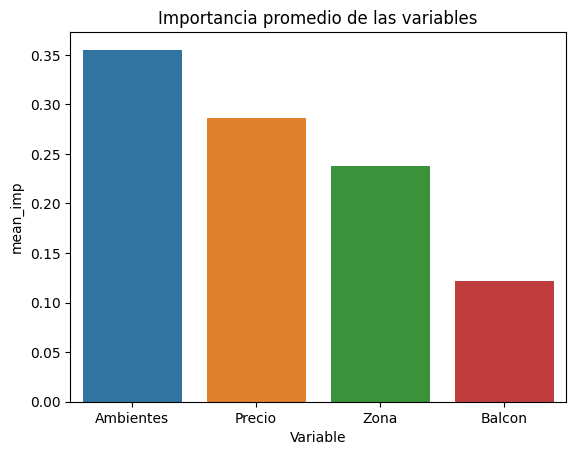

In [882]:
sns.barplot(x='Variable',y='mean_imp',data=mean_imp)
plt.title('Importancia promedio de las variables')

### Punto 3
Grafique los valores parciales asociados al precio de cada encuestado. ¿Cuáles son las implicancias de estos gráficos en las decisiones de gestión? 

In [883]:
price_coeff = pd.DataFrame(columns=['Participante','Variable','coefficient']) # Abro df vacio
for participante in range(0,16):
    # Para cada participante:
    # Subseteo, me quedo solo con las de precio y appendeo
    df_participante = df_results[df_results['Participante'] == participante]
    df_participante = df_participante[df_participante['Variable'].str.contains('Precio')]
    price_coeff = price_coeff.append(df_participante, ignore_index=True)

# Reemplazo esto para que no me quede un string muy largo
price_coeff['Variable'] = price_coeff['Variable'].replace('Precio[T.$150.000]','150.000')
price_coeff['Variable'] = price_coeff['Variable'].replace('Precio[T.$200.000]','200.000')

In [884]:
price_coeff.head()

,Participante,Variable,coefficient,p_value
0,1,150.000,0.074324,0.920709
1,1,200.000,-3.000000,0.002201
2,2,150.000,-1.021678,0.294653
3,2,200.000,-3.166667,0.006802
4,3,150.000,-1.306306,0.022473


In [885]:
# Esta parte del script es para agregar la variable de 100.000 con coeff 0, que estaba en el intercepto
for i in range(1,16):
    price_coeff = price_coeff.append({'Participante': i, 'Variable': '100.000', 'coefficient': 0, 'p_value': 0}, ignore_index=True)
    price_coeff.sort_values(by=['Participante','Variable'], inplace=True)

In [886]:
price_coeff.head()

,Participante,Variable,coefficient,p_value
0,1,100.000,0.000000,0.000000
1,1,150.000,0.074324,0.920709
2,1,200.000,-3.000000,0.002201
3,2,100.000,0.000000,0.000000
4,2,150.000,-1.021678,0.294653


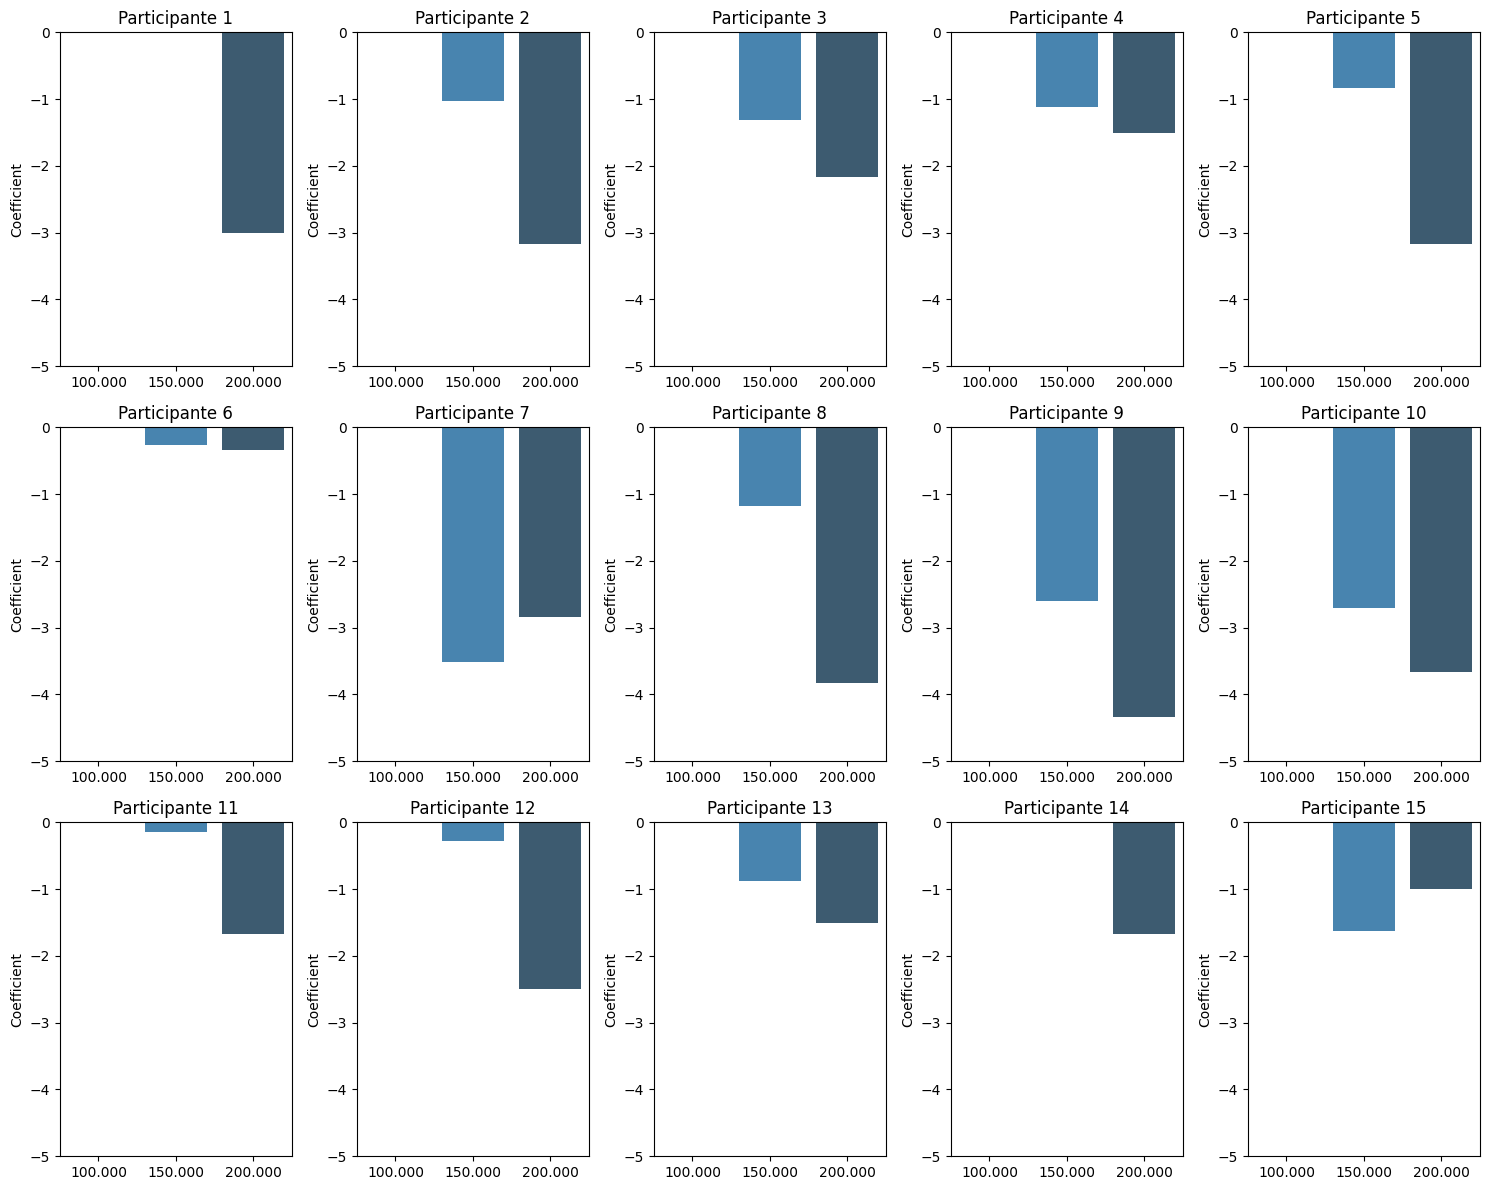

In [887]:
### Ploteando los coeficientes por participante 
# Me abro un subplot
fig, axs = plt.subplots(3, 5, figsize=(15, 12))

for i, ax in enumerate(axs.flat):
    # Para cada subplot:
    datos_participante = price_coeff[price_coeff['Participante'] == i+1] #Subsetting
    sns.barplot(x='Variable', y='coefficient', data=datos_participante, palette='Blues_d', ci=None, ax=ax) #Barplot
    # Formato
    ax.set_title(f'Participante {i+1}')
    ax.set_xlabel('')
    ax.set_ylim([-5,0])
    ax.set_ylabel('Coefficient')
    plt.tight_layout()

### Punto 4
¿Cuánto están dispuestos a pagar los consumidores por cambios en el atributo más
importante? (HINT: si precio es el atributo más importante, considere el segundo atributo
más importante). 


In [888]:
ut_df = pd.DataFrame(columns=['Participante','Variable','Price Utility']) # Abro df vacio
for i in range(1,16):
    # Para cada participante, subsetteo su parte del df con coeffs 
    df_participante = df_results[df_results['Participante'] == i]
    df_precio = df_participante[df_participante['Variable'].str.contains('Precio')]
    ## Utilidad de precio con nivel más alto
    u_max = df_precio.loc[df_precio['Variable'] == 'Precio[T.$200.000]','coefficient'].values[0]
    u_low = 0 ## utilidad de precio más bajo (esta en el intercepto)
    price_ut = u_low - u_max # Price utility
    ut_df = ut_df.append({'Participante': i, 'Variable': 'Precio[T.$100.000]', 'Price Utility': price_ut}, ignore_index=True) # Lo appendeo
    

In [889]:
ut_df

,Participante,Variable,Price Utility
0,1,Precio[T.$100.000],3.000000
1,2,Precio[T.$100.000],3.166667
2,3,Precio[T.$100.000],2.166667
3,4,Precio[T.$100.000],1.500000
4,5,Precio[T.$100.000],3.166667
5,6,Precio[T.$100.000],0.333333
6,7,Precio[T.$100.000],2.833333
7,8,Precio[T.$100.000],3.833333
8,9,Precio[T.$100.000],4.333333
9,10,Precio[T.$100.000],3.666667


In [890]:
## Ahora ya tenemos la price utility, hay que conseguir la utilidad del maximo de atributo de cada participante
max_ut_coeffs = pd.DataFrame(columns=['Participante','Variable','coefficient']) # Abro df vacio
for i in range(1,16):
    # Para cada participante quedemonos con el maximo de utilidad de atributo
    max_ut_col = var_importance.loc[var_importance.index == i,:].idxmax(axis=1).values[0]
    
    #En el loop, voy a programar diferentes casos donde en todos me quedo con los niveles y los coeficientes de la variable de máxima utilidad
    
    ## Caso 1. Variable más importante --> Ambientes
    if max_ut_col == 'Ambientes':
        print(f'Participante {i} --> Ambientes')
        max_ut_coef1 = df_results.loc[(df_results['Participante'] == i) & (df_results['Variable'] == 'Ambientes[T.3]'),'coefficient'].values[0]
        nivel_1 = 'Ambientes[T.3]'
        max_ut_coef2 = df_results.loc[(df_results['Participante'] == i) & (df_results['Variable'] == 'Ambientes[T.2]'),'coefficient'].values[0]
        nivel_2 = 'Ambientes[T.2]'
        max_ut_coef3 = np.nan
        nivel_3 = np.nan
    
    ## Caso 2. Variable más importante --> Balcón
    elif max_ut_col == 'Balcon':
        print(f'Participante {i} --> Balcon')
        max_ut_coef1 = df_results.loc[(df_results['Participante'] == i) & (df_results['Variable'] == 'Balcon[T.Si]'),'coefficient'].values[0]
        nivel_1 = 'Balcon[T.Si]'
        max_ut_coef2 = np.nan
        nivel_2 = np.nan
        max_ut_coef3 = np.nan
        nivel_3 = np.nan
    
    ## Caso 3. Variable más importante --> Precio
    elif max_ut_col == 'Precio':
        print(f'Participante {i} --> Precio, vamos a ver el segundo más importante')
        max_ut_col = var_importance.drop(columns='Precio').loc[var_importance.index == i,:].idxmax(axis=1).values[0]
        print(f' ---- Participante {i} --> {max_ut_col}')

        #En este dataset se dio que todos los que tenian como precio al más importante, el segundo fue la cantidad de ambientes
        # Asi que solo tuve que programar ese caso
        max_ut_coef1 = df_results.loc[(df_results['Participante'] == i) & (df_results['Variable'] == 'Ambientes[T.3]'),'coefficient'].values[0]
        nivel_1 = 'Ambientes[T.3]'
        max_ut_coef2 = df_results.loc[(df_results['Participante'] == i) & (df_results['Variable'] == 'Ambientes[T.2]'),'coefficient'].values[0]
        nivel_2 = 'Ambientes[T.2]'
        max_ut_coef3 = np.nan
        nivel_3 = np.nan

    ## Caso 4. Variable más importante --> Zona
    elif max_ut_col == 'Zona':
        print(f'Participante {i} --> Zona')
        max_ut_coef1 = df_results.loc[(df_results['Participante'] == i) & (df_results['Variable'] == 'Zona[T.Gba_Norte]'),'coefficient'].values[0]
        nivel_1 = 'Zona[T.Gba_Norte]'
        max_ut_coef2 = df_results.loc[(df_results['Participante'] == i) & (df_results['Variable'] == 'Zona[T.Gba_Sur]'),'coefficient'].values[0]
        nivel_2 = 'Zona[T.Gba_Sur]'
        max_ut_coef3 = df_results.loc[(df_results['Participante'] == i) & (df_results['Variable'] == 'Zona[T.Gba_Oeste]'),'coefficient'].values[0]
        nivel_3 = 'Zona[T.Gba_Oeste]'

    # Appendeamos los coeffs de cada atributo y nivel
    max_ut_coeffs = max_ut_coeffs.append({'Participante': i, 'Variable': max_ut_col, 'coefficient': max_ut_coef1, 'nivel': nivel_1}, ignore_index=True)
    max_ut_coeffs = max_ut_coeffs.append({'Participante': i, 'Variable': max_ut_col, 'coefficient': max_ut_coef2, 'nivel': nivel_2}, ignore_index=True)
    max_ut_coeffs = max_ut_coeffs.append({'Participante': i, 'Variable': max_ut_col, 'coefficient': max_ut_coef3, 'nivel': nivel_3}, ignore_index=True)
    del max_ut_coef1, max_ut_coef2, max_ut_coef3 # Borramos las variables para que no se pisen en el loop

#Droppeamos NA que fuimos generando en el proceso y estan de más
max_ut_coeffs.dropna(inplace=True)

Participante 1 --> Ambientes
Participante 2 --> Ambientes
Participante 3 --> Ambientes
Participante 4 --> Ambientes
Participante 5 --> Ambientes
Participante 6 --> Ambientes
Participante 7 --> Ambientes
Participante 8 --> Precio, vamos a ver el segundo más importante
 ---- Participante 8 --> Ambientes
Participante 9 --> Precio, vamos a ver el segundo más importante
 ---- Participante 9 --> Ambientes
Participante 10 --> Precio, vamos a ver el segundo más importante
 ---- Participante 10 --> Ambientes
Participante 11 --> Ambientes
Participante 12 --> Ambientes
Participante 13 --> Zona
Participante 14 --> Zona
Participante 15 --> Balcon


In [891]:
max_ut_coeffs.head(3)

,Participante,Variable,coefficient,nivel
0,1,Ambientes,4.259009,Ambientes[T.3]
1,1,Ambientes,2.092342,Ambientes[T.2]
3,2,Ambientes,3.355011,Ambientes[T.3]


In [892]:
ut_df.head(3)

,Participante,Variable,Price Utility
0,1,Precio[T.$100.000],3.000000
1,2,Precio[T.$100.000],3.166667
2,3,Precio[T.$100.000],2.166667


In [893]:
# Mergeo los dos df
max_ut_coeffs = max_ut_coeffs.merge(ut_df[['Participante','Price Utility']], on='Participante', how='left')

In [894]:
max_ut_coeffs

,Participante,Variable,coefficient,nivel,Price Utility
0,1,Ambientes,4.259009,Ambientes[T.3],3.000000
1,1,Ambientes,2.092342,Ambientes[T.2],3.000000
2,2,Ambientes,3.355011,Ambientes[T.3],3.166667
3,2,Ambientes,1.521678,Ambientes[T.2],3.166667
4,3,Ambientes,2.806306,Ambientes[T.3],2.166667
5,3,Ambientes,1.639640,Ambientes[T.2],2.166667
6,4,Ambientes,3.282376,Ambientes[T.3],1.500000
7,4,Ambientes,1.949043,Ambientes[T.2],1.500000
8,5,Ambientes,4.005068,Ambientes[T.3],3.166667
9,5,Ambientes,2.505068,Ambientes[T.2],3.166667


In [895]:
price_range = 200000 - 100000 # Cálculo del price range (Max price tier - Min price tier)

In [896]:
## Finalmente, cálculo del willingness to pau
max_ut_coeffs['w_to_pay'] = max_ut_coeffs['coefficient'] * price_range / max_ut_coeffs['Price Utility'] 

Breve análisis del cuadro

In [897]:
# Promedio que pagarian por cambio en atributo
max_ut_coeffs['w_to_pay'].mean()

106666.60120157583

In [898]:
# Promedio por atributo y nivel
max_ut_coeffs.groupby(['Variable','nivel']).mean()

coefficient  Price Utility       w_to_pay
Variable  nivel                                                       
Ambientes Ambientes[T.2]        1.796242       2.680556  106176.632435
          Ambientes[T.3]        3.296242       2.680556  179786.036285
Balcon    Balcon[T.Si]          3.405405       1.000000  340540.540541
Zona      Zona[T.Gba_Norte]     1.087838       1.583333   62899.774775
          Zona[T.Gba_Oeste]    -2.412162       1.583333 -153766.891892
          Zona[T.Gba_Sur]      -2.229730       1.583333 -141846.846847

Preparación para guardar en excel

In [899]:
max_ut_coeffs.rename(columns={'Variable':'Atributo más importante', 'nivel':'Nivel de atributo'}, inplace=True)

In [900]:
max_ut_coeffs.to_excel('Willigness to pay.xlsx',index=False)

### Punto 5
Realice una segmentación de sus encuestados basándose en las preferencias obtenidas
mediante la regresión. Comente respecto a los segmentos obtenidos. ¿Qué
producto/servicio podría ofrecer a cada segmento? (HINT: considere no más de 4
segmentos). 


In [901]:
## Importando paquete para KMeans
from sklearn.cluster import KMeans

c:\Users\lucas\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Clusters: 1 --> Inertia: 0.6609015224311526


c:\Users\lucas\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Clusters: 2 --> Inertia: 0.4444007540275494


c:\Users\lucas\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Clusters: 3 --> Inertia: 0.28225925197244545


c:\Users\lucas\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Clusters: 4 --> Inertia: 0.1980536787967258


c:\Users\lucas\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Clusters: 5 --> Inertia: 0.14761218919515928


c:\Users\lucas\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Clusters: 6 --> Inertia: 0.10340844782054223


c:\Users\lucas\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Clusters: 7 --> Inertia: 0.06700801836169454


c:\Users\lucas\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Clusters: 8 --> Inertia: 0.04688495636433538


c:\Users\lucas\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Clusters: 9 --> Inertia: 0.031478731133863604


c:\Users\lucas\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Clusters: 10 --> Inertia: 0.01829186893738681


c:\Users\lucas\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Clusters: 11 --> Inertia: 0.01063160187098829


([<matplotlib.axis.XTick at 0x28b63192eb0>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11')])

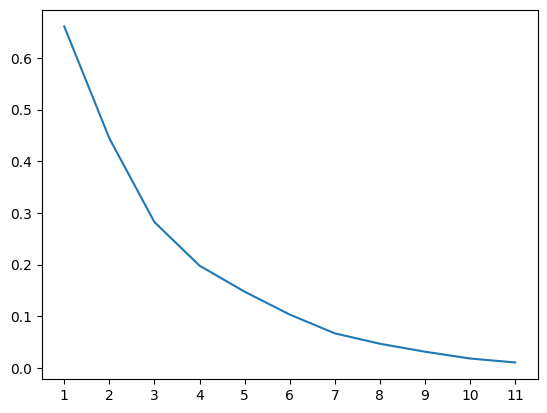

In [902]:
## Metodo del codo
innertia = []
for i in range(1,12):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(var_importance.reset_index().drop(columns='Participante'))
    print(f'Clusters: {i} --> Inertia: {kmeans.inertia_}')
    innertia.append(kmeans.inertia_)
plt.plot(range(1,12), innertia)
plt.xticks(range(1,12))

Entre 3 y 4 parecerían el número adecuado de clusters, vamos con 4

In [903]:
## Fitteamos modelos y creamos columna con el numero de cluster
knn = KMeans(n_clusters=4, random_state=0)
knn.fit(var_importance.reset_index().drop(columns='Participante'))
var_importance['Cluster'] = knn.labels_ + 1

c:\Users\lucas\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [904]:
var_importance.head(2)

Variable,Ambientes,Balcon,Precio,Zona,Cluster
Participante,,,,,
1,0.394123,0.142559,0.284494,0.178825,1
2,0.385751,0.106432,0.364095,0.143722,1


In [905]:
## Análisis de importancia por cluster
cluster_data = var_importance.groupby('Cluster').mean().reset_index()
cluster_data.set_index('Cluster', inplace=True)

In [906]:
cluster_data

Variable,Ambientes,Balcon,Precio,Zona
Cluster,,,,
1,0.347390,0.087267,0.355835,0.209508
2,0.270958,0.022193,0.225169,0.481680
3,0.471926,0.189992,0.144963,0.193120
4,0.242698,0.420584,0.201530,0.135188


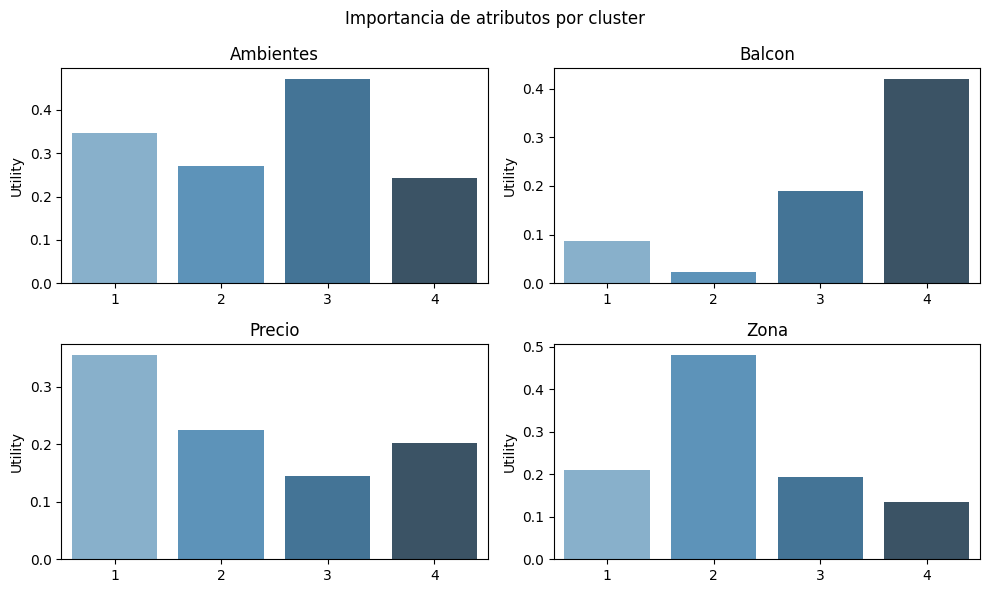

In [907]:
# Gráfico de importancia de atributos por cluster
plt.figure(figsize=(10,6))
for i in range(1,5):
    plt.subplot(2,2,i)
    sns.barplot(x=cluster_data.index,y=cluster_data.iloc[:,i-1], data=cluster_data, palette='Blues_d', ci=None)
    plt.suptitle('Importancia de atributos por cluster')
    plt.title(var_importance.columns[i-1])
    plt.xlabel('')
    plt.ylabel('Utility')
    plt.tight_layout()

### Punto 6
Genere dos perfiles de productos que no aparezcan en su cuestionario. Suponga que
actualmente éstos son los únicos productos en el mercado ofrecidos por los competidores
X e Y. Basándose en el total de sus encuestas, ¿cuál sería su estimación sobre la
participación de mercado para cada uno de estos productos? 

El intercepto corresponde a un departamento:
- En CABA
- Sin Balcón
- De 1 ambiente
- De $100.000 mensuales

In [908]:
# Armamos los departamentos

### Departamento 1
depto_1 = ['Ambientes[T.2]','Balcon[T.Si]','Precio[T.$150.000]','Zona[T.CABA]']

### Departamento 2
depto_2 = ['Ambientes[T.3]','Balcon[T.No]','Precio[T.$150.000]','Zona[T.Gba_Norte]']

In [909]:
puntajes = pd.DataFrame(columns=['Participante','Depto 1','Depto 2'])
for i in range(1,16):
    # Para cada participante, obtengo su intercepto
    df_participante = df_results[df_results['Participante'] == i]
    intercepto = df_participante.loc[df_participante['Variable'] == 'Intercept','coefficient'].values[0]
    puntaje_1 = intercepto
    puntaje_2 = intercepto
    for j in depto_1:
        if j in df_participante['Variable'].unique():
            # Para cada variable en el depto 1, si esta en el df del participante, le sumo el coeficiente
            puntaje_1 = puntaje_1 + df_participante.loc[df_participante['Variable'] == j,'coefficient'].values[0]
    for k in depto_2:
        if k in df_participante['Variable'].unique():
            # Para cada variable en el depto 2, si esta en el df del participante, le sumo el coeficiente
            puntaje_2 = puntaje_2 + df_participante.loc[df_participante['Variable'] == k,'coefficient'].values[0]
    
    puntajes = puntajes.append({'Participante': i, 'Depto 1': puntaje_1, 'Depto 2': puntaje_2}, ignore_index=True)

In [910]:
# Regla de decisión, si el puntaje del depto 1 es mayor al del depto 2, el participante elige el depto 1, sino el depto 2
puntajes['Depto'] = [1 if x > y else 2 for x,y in zip(puntajes['Depto 1'],puntajes['Depto 2'])]

In [911]:
puntajes['Depto'].value_counts()

2    9
1    6
Name: Depto, dtype: int64

In [912]:
puntajes['Depto'].value_counts(normalize=True)

2    0.6
1    0.4
Name: Depto, dtype: float64

Vamos a ver si la segmentación realizada en el punto anterior detecta bien la diferencia entre quienes prefieren un depto u otro

In [913]:
puntajes = pd.merge(puntajes,var_importance['Cluster'],on='Participante')

In [914]:
puntajes

,Participante,Depto 1,Depto 2,Depto,Cluster
0,1.0,7.227477,7.688063,2,1
1,2.0,5.190597,5.703829,2,1
2,3.0,4.234234,6.144144,2,1
3,4.0,8.090935,7.382883,1,3
4,5.0,8.518581,8.722973,2,1
5,6.0,7.214245,5.612613,1,3
6,7.0,5.087556,6.717342,2,1
7,8.0,6.901464,8.400901,2,1
8,9.0,6.070101,5.341216,1,1
9,10.0,5.523086,5.610360,2,1


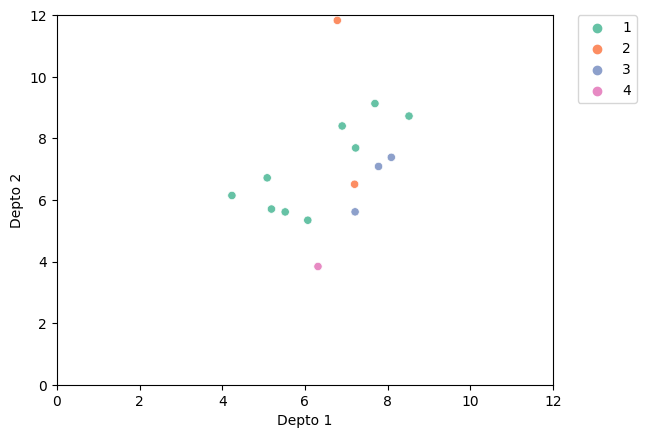

In [915]:
sns.scatterplot(x='Depto 1',y='Depto 2',data=puntajes,hue='Cluster',palette='Set2')
plt.xlim([0,12])
plt.ylim([0,12])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [916]:
display(puntajes.groupby('Cluster')['Depto 1','Depto 2'].mean())
puntaje_cluster = puntajes.groupby('Cluster')['Depto 1','Depto 2'].mean()

,Depto 1,Depto 2
Cluster,,
1,6.271991,7.050926
2,6.993243,9.168919
3,7.695571,6.694069
4,6.316441,3.838964


Text(0.5, 1.0, 'Puntaje promedio por cluster')

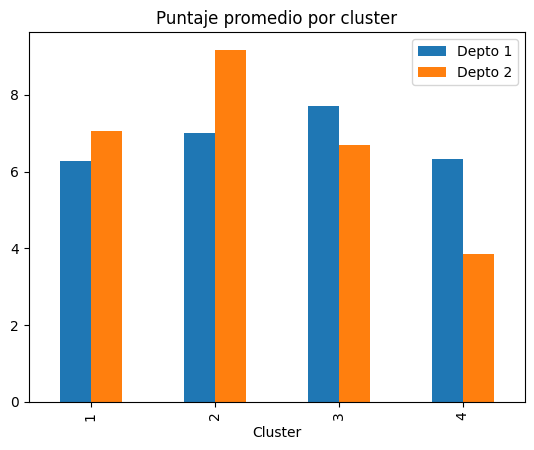

In [917]:
puntaje_cluster.plot(kind='bar')
plt.title('Puntaje promedio por cluster')